# Training Mistral based models

Adapted from: https://colab.research.google.com/github/brevdev/notebooks/blob/main/mixtral-finetune-own-data.ipynb


In [59]:
import json
import torch
import transformers
import random
import shutil

import matplotlib.pyplot as plt

from   datetime                import datetime
from   pathlib                 import Path
from   sklearn.model_selection import train_test_split
from   transformers            import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from   peft                    import prepare_model_for_kbit_training
from   peft                    import LoraConfig, get_peft_model, PeftModel

from   accelerate                                         import FullyShardedDataParallelPlugin, Accelerator
from   torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig



### Load the dataset, shuffle it and perform the train/test split

In [60]:
lrn_dataset = []
cnt         = 0
with open('dataset.jsonl') as f:
    lrn_dataset = [json.loads(l) for l in f]

random.shuffle(lrn_dataset)
train_d, test_d = train_test_split(lrn_dataset)

### Setup the prompt

In [61]:
system_prompt = "Identify if the text provided by user is related to Fablabs and the techniques and skills related or have no relevance to Fablabs, "       \
              + "provide the answer entirely in a json format containing a key \"text\" key containing the text under analysis and a \"fablab\" key "       \
              + "containing 1 if the text is related to Fablabs 0 otherwise"

verif_text    = "DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance"


eval_prompt   = f"<|system|>\n{system_prompt}\n<|user|>\n{verif_text}</s>\n<|assistant|>\n"
verif_dict    = {'text': verif_text, 'fablab':1}



In [62]:
base_model_id   = "HuggingFaceH4/zephyr-7b-beta"
project         = "fablab_finetune"
base_model_name = base_model_id.split('/')[-1]
run_name        = base_model_name + "_" + project
output_dir      = "./" + run_name
output_dir_pth  = Path(output_dir)

bnb_config    = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = torch.bfloat16
)

tokenizer     = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side              = "left",
    add_eos_token             = True,
    add_bos_token             = True,
)
tokenizer.pad_token = tokenizer.eos_token

def formatting_func(example):
    text = f"<|system|>\n{system_prompt}\n<|user|>\n{example['text']}</s>\n<|assistant|>\n {{\"text\": \"{example['text']}\", \"fablab\": {1 if example['fablab'] == 1 else 0} }} "
    return text

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


print(formatting_func(verif_dict))     #test it

<|system|>
Identify if the text provided by user is related to Fablabs and the techniques and skills related or have no relevance to Fablabs, provide the answer entirely in a json format containing a key "text" key containing the text under analysis and a "fablab" key containing 1 if the text is related to Fablabs 0 otherwise
<|user|>
DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance</s>
<|assistant|>
 {"text": "DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance", "fablab"

In [63]:
#tokenized_train_d = train_d.map(generate_and_tokenize_prompt)
#tokenized_test_d  = test_d.map(generate_and_tokenize_prompt)

tokenized_train_d = list(map(generate_and_tokenize_prompt, train_d))
tokenized_test_d  = list(map(generate_and_tokenize_prompt, test_d ))

In [64]:
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [65]:
def plot_data_lengths(tokenize_train_dataset, tokenized_test_d):
    lengths  = [len(x['input_ids']) for x in tokenized_train_d]
    lengths += [len(x['input_ids']) for x in tokenized_test_d ]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

50


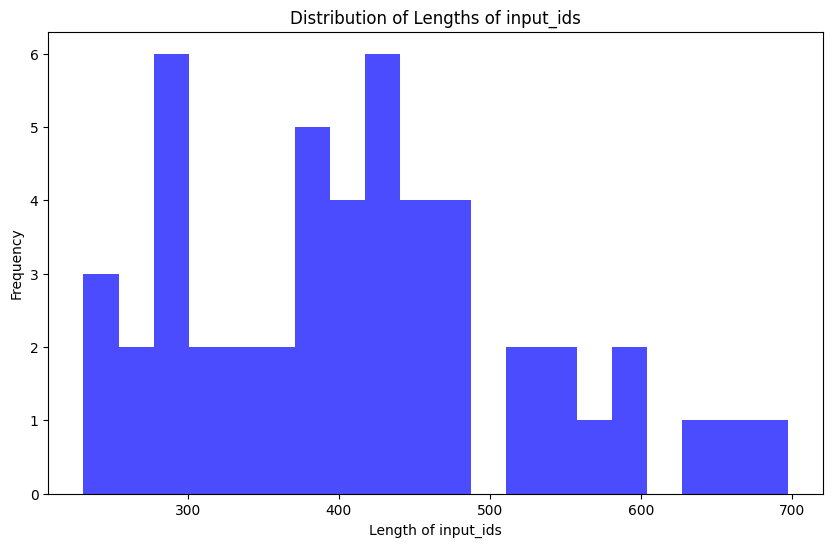

In [66]:
plot_data_lengths(tokenized_train_d, tokenized_test_d)

In [67]:
max_length = 1024 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result


## Test existing model

In [68]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [69]:
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<|system|>
Identify if the text provided by user is related to Fablabs and the techniques and skills related or have no relevance to Fablabs, provide the answer entirely in a json format containing a key "text" key containing the text under analysis and a "fablab" key containing 1 if the text is related to Fablabs 0 otherwise
<|user|>
DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance 
<|assistant|>
{
  "text": {
    "value": "DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Allia

## train preparation

In [70]:
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
model = prepare_model_for_kbit_training(model)

In [71]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param        = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [72]:
print(model)


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=2)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
  

In [73]:
config = LoraConfig(
    r              = 32,
    lora_alpha     = 64,
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias           = "none",
    lora_dropout   = 0.05,  # Conventional
    task_type      = "CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

print(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=

In [74]:
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config       = FullStateDictConfig(     offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config = FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
model       = accelerator.prepare_model(model)

In [75]:
resume_from_ckp = False
warm_st         = 1
train_passes    = 2
steps           = warm_st + len(tokenized_train_d) * train_passes

print(f"Training for {steps} steps")
trainer      = transformers.Trainer(
                model         = model,
                train_dataset = tokenized_train_d,
                eval_dataset  = tokenized_test_d,
                args          = transformers.TrainingArguments(
                    output_dir                  = output_dir,
                    warmup_steps                = warm_st,
                    per_device_train_batch_size = 2,
                    gradient_accumulation_steps = 1,
                    max_steps                   = steps,
                    learning_rate               = 1.0e-5,             # Want a small lr for finetuning
                    bf16                        = True,
                    optim                       = "paged_adamw_8bit",
                    logging_steps               = 5,                  # When to start reporting loss
                    logging_dir                 = "./logs",           # Directory for storing logs
                    save_strategy               = "steps",            # Save the model checkpoint every logging step
                    save_steps                  = 5,                  # Save checkpoints every 50 steps
                    evaluation_strategy         = "steps",            # Evaluate the model every logging step
                    eval_steps                  = 5,                  # Evaluate and save checkpoints every 50 steps
                    do_eval                     = True,               # Perform evaluation at the end of training
                    #report_to                   = "wandb",           # Comment this out if you don't want to use weights & baises
                    run_name                    = f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


Training for 75 steps


## run training

In [76]:
if resume_from_ckp:
    if output_dir_pth.exists():
        print("Loading from checkpoint")
        trainer.train(resume_from_checkpoint=output_dir_pth)
else:
    if output_dir_pth.exists():
        print("Deleting old checkpoint")
        #output_dir_pth.rmdir()
        shutil.rmtree(output_dir_pth, ignore_errors=True)
        
trainer.train()

Deleting old checkpoint


  0%|          | 0/75 [00:00<?, ?it/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.4899, 'learning_rate': 9.45945945945946e-06, 'epoch': 0.26}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3040425777435303, 'eval_runtime': 1.839, 'eval_samples_per_second': 7.069, 'eval_steps_per_second': 1.088, 'epoch': 0.26}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.2588, 'learning_rate': 8.783783783783785e-06, 'epoch': 0.53}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1751329898834229, 'eval_runtime': 1.8285, 'eval_samples_per_second': 7.11, 'eval_steps_per_second': 1.094, 'epoch': 0.53}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.1588, 'learning_rate': 8.108108108108109e-06, 'epoch': 0.79}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0848262310028076, 'eval_runtime': 1.8644, 'eval_samples_per_second': 6.973, 'eval_steps_per_second': 1.073, 'epoch': 0.79}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 1.1307, 'learning_rate': 7.4324324324324324e-06, 'epoch': 1.05}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9888514876365662, 'eval_runtime': 1.8428, 'eval_samples_per_second': 7.054, 'eval_steps_per_second': 1.085, 'epoch': 1.05}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.9121, 'learning_rate': 6.7567567567567575e-06, 'epoch': 1.32}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8986876606941223, 'eval_runtime': 1.8597, 'eval_samples_per_second': 6.991, 'eval_steps_per_second': 1.075, 'epoch': 1.32}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.7945, 'learning_rate': 6.081081081081082e-06, 'epoch': 1.58}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8429532647132874, 'eval_runtime': 1.8488, 'eval_samples_per_second': 7.032, 'eval_steps_per_second': 1.082, 'epoch': 1.58}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.7002, 'learning_rate': 5.405405405405406e-06, 'epoch': 1.84}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8161913156509399, 'eval_runtime': 1.8381, 'eval_samples_per_second': 7.072, 'eval_steps_per_second': 1.088, 'epoch': 1.84}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.7418, 'learning_rate': 4.72972972972973e-06, 'epoch': 2.11}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8041848540306091, 'eval_runtime': 1.8445, 'eval_samples_per_second': 7.048, 'eval_steps_per_second': 1.084, 'epoch': 2.11}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6424, 'learning_rate': 4.0540540540540545e-06, 'epoch': 2.37}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8015544414520264, 'eval_runtime': 1.8454, 'eval_samples_per_second': 7.045, 'eval_steps_per_second': 1.084, 'epoch': 2.37}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.7166, 'learning_rate': 3.3783783783783788e-06, 'epoch': 2.63}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8011030554771423, 'eval_runtime': 1.8663, 'eval_samples_per_second': 6.966, 'eval_steps_per_second': 1.072, 'epoch': 2.63}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.7317, 'learning_rate': 2.702702702702703e-06, 'epoch': 2.89}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7999594211578369, 'eval_runtime': 1.8658, 'eval_samples_per_second': 6.967, 'eval_steps_per_second': 1.072, 'epoch': 2.89}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6727, 'learning_rate': 2.0270270270270273e-06, 'epoch': 3.16}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7995823621749878, 'eval_runtime': 1.8657, 'eval_samples_per_second': 6.968, 'eval_steps_per_second': 1.072, 'epoch': 3.16}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6044, 'learning_rate': 1.3513513513513515e-06, 'epoch': 3.42}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.798859715461731, 'eval_runtime': 1.8657, 'eval_samples_per_second': 6.968, 'eval_steps_per_second': 1.072, 'epoch': 3.42}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6472, 'learning_rate': 6.756756756756758e-07, 'epoch': 3.68}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7981175780296326, 'eval_runtime': 1.8648, 'eval_samples_per_second': 6.971, 'eval_steps_per_second': 1.073, 'epoch': 3.68}


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/torch/utils/checkpoint.py:461: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


{'loss': 0.6178, 'learning_rate': 0.0, 'epoch': 3.95}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.798119843006134, 'eval_runtime': 1.8629, 'eval_samples_per_second': 6.978, 'eval_steps_per_second': 1.074, 'epoch': 3.95}
{'train_runtime': 95.6621, 'train_samples_per_second': 1.568, 'train_steps_per_second': 0.784, 'train_loss': 0.8546417077382406, 'epoch': 3.95}


TrainOutput(global_step=75, training_loss=0.8546417077382406, metrics={'train_runtime': 95.6621, 'train_samples_per_second': 1.568, 'train_steps_per_second': 0.784, 'train_loss': 0.8546417077382406, 'epoch': 3.95})

## test model

In [77]:


base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,                     # same as before
    quantization_config = bnb_config,  # Same quantization config as before
    device_map          = "auto",
    trust_remote_code   = True,
    #use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [78]:
ft_model = PeftModel.from_pretrained(base_model, run_name + "/checkpoint-50")


In [79]:
print(eval_prompt)

<|system|>
Identify if the text provided by user is related to Fablabs and the techniques and skills related or have no relevance to Fablabs, provide the answer entirely in a json format containing a key "text" key containing the text under analysis and a "fablab" key containing 1 if the text is related to Fablabs 0 otherwise
<|user|>
DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance</s>
<|assistant|>



In [80]:

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))


/home/me/miniforge3/envs/ab311/lib/python3.11/site-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<|system|>
Identify if the text provided by user is related to Fablabs and the techniques and skills related or have no relevance to Fablabs, provide the answer entirely in a json format containing a key "text" key containing the text under analysis and a "fablab" key containing 1 if the text is related to Fablabs 0 otherwise
<|user|>
DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance 
<|assistant|>
 {"text": "DigiCon is an interactive, creative, inspiring event exploring how anyone can change the world using the new tools of digital fabrication.  In its 8th year, the 2019 DigiCon will focus on Digital Badges, a platform for verifying skills and accomplishments through the North American Digital Fabrication Alliance ", "fablab": 